In [1]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score, brier_score_loss, f1_score
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
from skopt import BayesSearchCV
import skopt.space as space
import skopt.plots as plots
import imblearn
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from ff_custom_scripts import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import KNNImputer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score


In [2]:
train, test,leaderboard,holdout = load_files(nanvalues='keep')

alldata = pd.concat([train, test]) # all data available for training in the FF Challenge

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1438) (294, 1438) (530, 1438) (803, 1438)


In [3]:
meta.head(5)

,varlab,type,one_topic,dtype
new_name,,,,
f1a2,Were you present at the birth?,Binary,parenting,float64
f1a3,Have you held baby(ies)?,Binary,parenting,float64
f1a4,Will the baby(ies) have your last name?,Binary,parenting,float64
f1a5,Will your name be on the birth certificate?,Binary,parenting,float64
f1a6,Do you have other biological children?,Binary,health_and_health_behavior,float64


# Model

In [4]:
def run_model(train, target='gpa', classifier=False):

    X_train, y_train = prepare_data(train, target)
    
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    ordered_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('target', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ])

    numerical_features = cols_per_type(X_train, 'Continuous')
    categorical_features = cols_per_type(X_train, 'Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    ordinal_features = cols_per_type(X_train, 'Ordinal')
    
    preprocessor = make_column_transformer(
        (categorical_transformer, categorical_features),
        ('passthrough', numerical_features),
        (ordered_transformer, ordinal_features),
        ('passthrough', binary_features)
    )
    
    search_space = {
            'regressor__n_estimators': space.Integer(600, 1500),
            'regressor__learning_rate': space.Real(0.01, 0.06),
            'regressor__max_depth': space.Integer(5, 10),
            'regressor__min_child_weight': space.Integer(3, 5),
            'regressor__gamma': space.Real(0.1, 0.25),
        }
    
    if classifier:
        score = 'neg_brier_score'
        xgboost = XGBClassifier(n_jobs=-1, eval_metric='logloss', objective='binary:logistic')
        search_space.update({'regressor__scale_pos_weight': space.Integer(2, 17)})
           
    else:
        xgboost = XGBRegressor(n_jobs=-1, eval_metric='rmse')
        score = 'neg_mean_squared_error'
    
        
    pipes = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', xgboost)])
                            
    model = BayesSearchCV(
        pipes,
        search_space,
        n_iter=10,
        cv=5,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=0,
        random_state=32
    )
    
    model.fit(X_train, y_train)
    
    return model


# GPA

In [5]:
gpa_model = run_model(train,target='gpa', classifier=False)

In [6]:
# Woodcock-Johnson Test 10 standard score
#  f3b3	0.01004	How many times have you been apart for a week or more?
#  m2c3j	0.00904	How many days a week does father put child to bed?

In [7]:
score_model(gpa_model,'gpa',test,leaderboard,holdout,classifier=False)

Metric: mean_squared_error
Best CV score: 0.4104
Standard deviation of CV scores: 0.0366
Mean CV score: 0.4177
Test MSE: 0.4339
Test R2: 0.0465
Leaderboard MSE: 0.5405
Leaderboard R2: -0.3838
Holdout MSE: 0.5715
Holdout R2: -0.3537


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


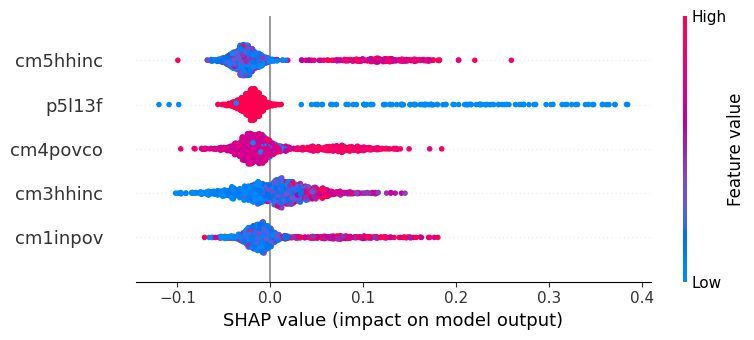

{("Constructed - Mother's Household income (with imputed values)",): 'cm1inpov',
 ('L13F. Gifted and talented program',): 'cm3hhinc',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'cm5hhinc',
 ('Constructed - Household income (with imputed values)',): 'p5l13f'}

In [8]:
shap_show(gpa_model, alldata, target='gpa')

# Material Hardship

In [9]:
model_materialHardship = run_model(train,target='materialHardship', classifier=False)

In [10]:
model_materialHardship.best_params_

OrderedDict([('regressor__gamma', 0.19650928713511362),
             ('regressor__learning_rate', 0.0454974682905599),
             ('regressor__max_depth', 10),
             ('regressor__min_child_weight', 4),
             ('regressor__n_estimators', 986)])

In [11]:
score_model(model_materialHardship, target='materialHardship', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

# run after here

Metric: mean_squared_error
Best CV score: 0.0202
Standard deviation of CV scores: 0.0020
Mean CV score: 0.0204
Test MSE: 0.0236
Test R2: 0.1335
Leaderboard MSE: 0.0310
Leaderboard R2: -0.0835
Holdout MSE: 0.0277
Holdout R2: -0.1348


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


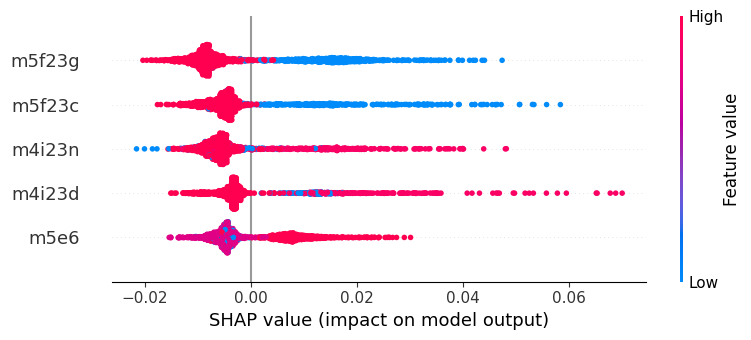

{('F23G. Borrowed money from friends/family to help pay bills in past 12 months',): 'm5e6',
 ('F23C. Did not pay full amount of rent/mortgage payments in past 12 months',): 'm4i23d',
 ("In past year, phone service disconnected b/c wasn't enough money?",): 'm4i23n',
 ("In past year, did not pay full amt rent/mortgage payments b/c wasn't enough",): 'm5f23c',
 ('E6. Mother could count on someone to co-sign for a bank loan for $1000',): 'm5f23g'}

In [12]:
shap_show(model_materialHardship, alldata, target='materialHardship')


# Grit


In [13]:
model_grit = run_model(train,target='grit', classifier=False)

In [14]:
# Value 2 for “(He/she) stares blankly.”
#  hv4r10a_3_1	0.01520	Value 1 for “Any hazardous condition 3: broken glass”
#  hv5_wj9raw	0.00946	Woodcock-Johnson Test 9 raw score

In [15]:
model_grit.best_params_

OrderedDict([('regressor__gamma', 0.22614724810253625),
             ('regressor__learning_rate', 0.014685155182751344),
             ('regressor__max_depth', 7),
             ('regressor__min_child_weight', 5),
             ('regressor__n_estimators', 1438)])

In [16]:
score_model(model_grit, target='grit', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

Metric: mean_squared_error
Best CV score: 0.2405
Standard deviation of CV scores: 0.0305
Mean CV score: 0.2436
Test MSE: 0.2409
Test R2: -0.0229
Leaderboard MSE: 0.2834
Leaderboard R2: -0.2897
Holdout MSE: 0.3218
Holdout R2: -0.3472


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


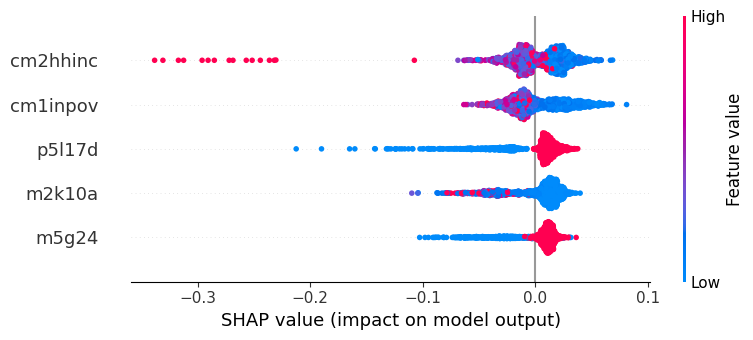

{('Constructed - Household income (with imputed values)',): 'm5g24',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'm2k10a',
 ("L17D. Discussed homework not done with child's teacher in this/last school year",): 'p5l17d',
 ('About how much (do/did) you usually earn in (this/that) job, before taxes?',): 'cm1inpov',
 ('G24. Ever had a spell/attack when you felt frightened/anxious/uneasy',): 'cm2hhinc'}

In [17]:
shap_show(model_grit, alldata, target='grit')

# Eviction

In [18]:
model_eviction = run_model(train,target='eviction', classifier=True)

In [19]:
score_model(model_eviction, 'eviction', test, leaderboard, holdout=None, classifier=True)

Test Brier: 0.0619
Test F1: 0.0000
Leaderboard Brier: 0.0906
Leaderboard F1: 0.0769


In [20]:
# Value “yes” for “Telephone service disconnected because wasn’t enough money in past 12 months.”
#  m5f23c_1	0.05842	Value “yes” for “Did not pay full amount of rent/mortgage payments in past 12 months.”
#  m3i4	0.02062	How much rent do you pay each month?

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


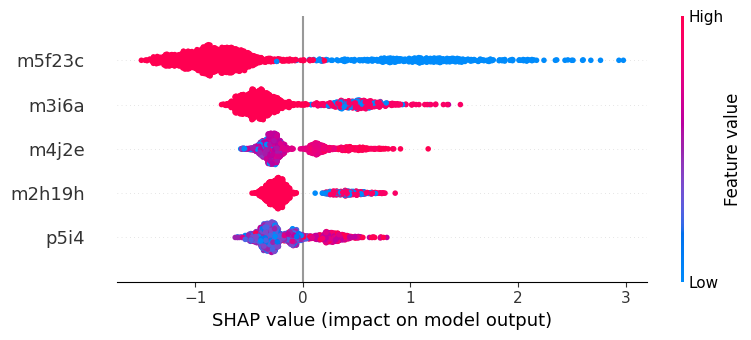

{('F23C. Did not pay full amount of rent/mortgage payments in past 12 months',): 'p5i4',
 ('In past year, was telephone service ever disconnected?',): 'm2h19h',
 ('How much do you weigh?',): 'm4j2e',
 ('In past year, did your-Telephone service get disconnected for nonpayment?',): 'm3i6a',
 ('I4. Amount of time child watches TV or videos on a weekend day',): 'm5f23c'}

In [21]:
shap_show(model_eviction, alldata, target='eviction')

In [22]:
# top5 = ['m5f23k','p3m39','m5i3c']

# meta[meta.index.isin(top5)].varlab.values

# jobTraining

In [23]:
# Value “yes” for “In the last 2 years, have you taken any classes to improve your job skills?”
#  m5i1_1	0.06355	Value “yes” for “You are currently attending any school/trainings program/classes.”
#  m5i3b_1	0.06355	Value “yes” for “You have taken classes to improve job skills since last interview.”

In [24]:
model_job = run_model(train,target='jobTraining', classifier=True)

In [25]:
score_model(model_job, 'jobTraining', test, leaderboard, holdout=None, classifier=True)

Test Brier: 0.2671
Test F1: 0.1875
Leaderboard Brier: 0.3377
Leaderboard F1: 0.1268


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


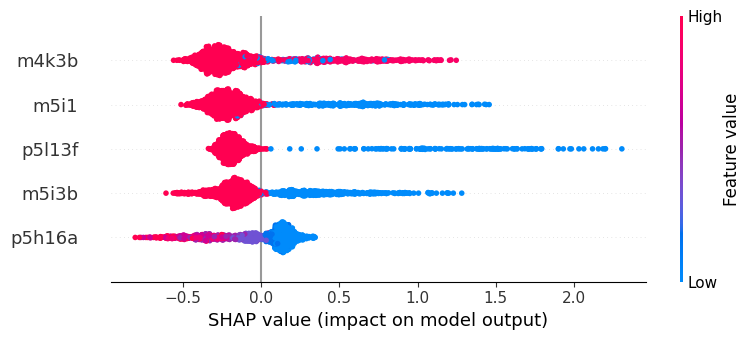

{('In the last 2 years, have you taken any classes to improve your job skills?',): 'p5h16a',
 ('I1. You are currently attending any school/trainings program/classes',): 'm5i3b',
 ('L13F. Gifted and talented program',): 'p5l13f',
 ('I3B. You have taken classes to improve job skills since last interview',): 'm5i1',
 ('H16A. Number of dental fillings child has had',): 'm4k3b'}

In [26]:
shap_show(model_job, alldata, target='jobTraining',n=5)

# Layoff

In [28]:
# mount of money spent eating out in last month
#  m3i0q	0.01678	How important is it to serve in the military when at war?
#  f5i13	0.01678	How much you earn in that job, before taxes

In [29]:
model_layoff = run_model(train, target='layoff', classifier=True)

In [30]:
model_layoff.best_params_

OrderedDict([('regressor__gamma', 0.19650928713511362),
             ('regressor__learning_rate', 0.0454974682905599),
             ('regressor__max_depth', 10),
             ('regressor__min_child_weight', 4),
             ('regressor__n_estimators', 986),
             ('regressor__scale_pos_weight', 2)])

In [31]:
score_model(model_layoff, 'layoff', test, leaderboard, holdout, classifier=True)

Test Brier: 0.2430
Test F1: 0.0000
Leaderboard Brier: 0.2547
Leaderboard F1: 0.1615
Holdout Brier: 0.2516


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


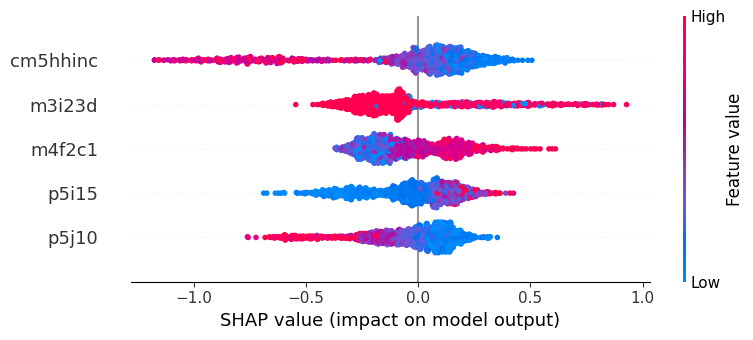

{("Constructed - Mother's Household income (with imputed values)",): 'p5j10',
 ('In past year, did you not pay full gas/oil/electricity bill?',): 'p5i15',
 ("What is first person's age? (years)",): 'm4f2c1',
 ('I15. Number of hours TV is on',): 'm3i23d',
 ('J10. Amount of money spent eating out in last month',): 'cm5hhinc'}

In [32]:
shap_show(model_layoff, alldata, target='layoff')